<h4 style="text-align:right">The Course of Computational Physics,&nbsp; Peking University</h4>
***
<p><br>
<h1 style="text-align:center"><font face="宋体" size=6>计算物理学第五次作业——补充gif</font></h1>
<br></p>
<h2 style="text-align:center"><font face="楷体">姓名:&nbsp;贺鑫</font> </h2>
<h2 style="text-align:center"> <font face="楷体">学号:&nbsp; _1500011805_</font></h2>

## 2 Kruskal Zulasky 孤立子
> Kruskal Zulasky 孤立子方程为：  
$$u_t+uu_x+\delta^2u_{xxx}=0,\,u(x,t=0)=cos(\pi x)$$
$$(u^{n+1}_k-u^{n-1}_{k})/2dt+\frac{1}{3}(u^{n}_{k-1}+u^{n}_{k}+u^{n}_{k+1})(u^n_{k+1}-u^n_{k-1})/2dx
+\delta^2 (u^n_{k+2}-2u^n_{k+1}+2u^n_{k-1}-u^n_{k-2})/2dx^3=0
$$
令$r=dt/dx$得到：
$$(u^{n+1}_k-u^{n-1}_{k})+\frac{r}{3}(u^{n}_{k-1}+u^{n}_{k}+u^{n}_{k+1})(u^n_{k+1}-u^n_{k-1})
+r(\frac{\delta}{dx})^2(u^n_{k+2}-2u^n_{k+1}+2u^n_{k-1}-u^n_{k-2})=0
$$
即
$$u^{n+1}_k=u^{n-1}_{k}-\frac{r}{3}(u^{n}_{k-1}+u^{n}_{k}+u^{n}_{k+1})(u^n_{k+1}-u^n_{k-1})
-r(\frac{\delta}{dx})^2(u^n_{k+2}-2u^n_{k+1}+2u^n_{k-1}-u^n_{k-2})=0
$$
(其中r的定义见程序)

In [ ]:
import numpy as np
import pandas as pd
from numba import jit
import matplotlib.pyplot as plt
%matplotlib inline
#np.seterr(all='ignore')

xini=0;xfin=2.0;xstep=200;
dx=(xfin-xini)/xstep;
xs=np.linspace(xini,xfin,xstep+1)

tini=0;tfin=20.0;tstep=100000000;
dt=(tfin-tini)/tstep;
ts=np.linspace(tini,tfin,tstep+1)

dp=0.05;
psmp = int(dp/dt);
pstep = int(tstep/psmp);

u=np.zeros((xstep+1,3))
data=np.zeros((xstep+1,pstep+1))

# for simple, we here define
r=dt/dx
delta=0.022
coeffa=r/3
coeffb=r*(delta/dx)**2

@jit(nopython=True)
def un(u,i,j):
    return (u[i+1,j]+u[i,j]+u[i-1,j])
@jit(nopython=True)
def ux(u,i,j):
    return (u[i+1,j]-u[i-1,j])  
@jit(nopython=True)
def uxxx(u,i,j):
    return (u[i+2,j]-2*u[i+1,j]+2*u[i-1,j]-u[i-2,j])
    # for u'''(u[i+2,j]-2*u[i+1,j]+2*u[i-1,j]-u[i-2,j]) / (2dx^3)

### initialization
@jit(nopython=True)
def initial(u):
    for i in range(xstep+1):
        u[i,0]=np.cos(np.pi*(xini+i*dx))
    return u

### first step, we need t0 and t1 as initial
@jit(nopython=True)
def first_step(u):
    u[0,1]=u[0,0] - 0.5*coeffa*(u[1,0]+u[0,0]+u[-2,0])*(u[1,0]-u[-2,0]) - 0.5*coeffb*(
        u[2,0]-2*u[1,0]+2*u[-2,0]-u[-3,0])
    u[1,1]=u[1,0] - 0.5*coeffa*un(u,1,1)*ux(u,1,1) - 0.5*coeffb*(
        u[3,0]-2*u[2,0]+2*u[0,0]-u[-2,0])
    for j in range(2,xstep-1):
        u[j,1]=u[j,0] - 0.5*coeffa*un(u,j,0)*ux(u,j,0) - 0.5*coeffb* uxxx(u,j,0)
    u[xstep-1,1]=u[xstep-1,0] - 0.5*coeffa*un(u,xstep-1,0)*ux(u,xstep-1,0) - 0.5*coeffb*(
        u[1,1]-2*u[xstep,1]+2*u[xstep-2,1]-u[xstep-3,1])
    u[xstep,1]=u[0,1]
    return u

### next steps
@jit(nopython=True)
def propagate(u,data,psmp,xstep,tstep):
    for i in range(1,tstep):#  n+1 time-points, with n time segments, snd from i=1
        u[0,2]=u[0,0] - coeffa*(u[1,1]+u[0,1]+u[-2,1])*(u[1,1]-u[-2,1]) - coeffb*(
            u[2,1]-2*u[1,1]+2*u[-2,1]-u[-3,1])
        u[1,2]=u[1,0] - coeffa*un(u,1,1)*ux(u,1,1) - coeffb*(
            u[3,1]-2*u[2,1]+2*u[0,1]-u[-2,1])
        for j in range(2,xstep-1):
            u[j,2]=u[j,0] - coeffa*un(u,j,1)*ux(u,j,1) - coeffb* uxxx(u,j,1)
        u[xstep-1,2]=u[xstep-1,0] - coeffa*un(u,xstep-1,1)*ux(u,xstep-1,1) - coeffb*(
            u[1,1]-2*u[xstep,1]+2*u[xstep-2,1]-u[xstep-3,1])
        u[xstep,2]=u[0,2]
        u[:,0]=u[:,1];
        u[:,1]=u[:,2];
        if(i%psmp==0):
            #if(u[0,0]==np.nan)
            #print("i do p\n", i//psmp,"!=",0,u[0,0],'!=','nan' )
            #    break;
            data[:,i//psmp]=u[:,0]
    return u,data

u=initial(u)
data[:,0]=u[:,0]
u=first_step(u)
u,data=propagate(u,data,psmp,xstep,tstep)

a=pd.DataFrame(data)
a.to_csv("KZ_LF.dat",header=None)
# the putout shows the procedure breakdown with nan values!

<IPython.core.display.Javascript object>


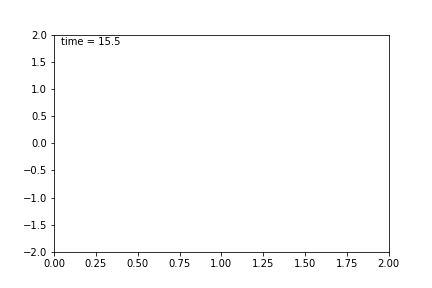

In [2]:
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'
from numba import jit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation

a=pd.read_csv("KZ_LF.dat",header=None)
data=a.values
xs=np.linspace(0,2,len(data[:,0]))
pstep=len(data[0,:])

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
# initialization function: plot the background of each frame
@jit
def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

# animation function.  This is called sequentially
@jit
def animate(i):
    line.set_data(xs, data[:,i])
    time_text.set_text('time = %.1f'%(0.05*i))
    return line, time_text

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=pstep+1, interval=50, blit=True)
plt.show()

> 可以发现，短时间演化后的解的行为比较良好（虽然$dx=0.01,\,dt=2\times 10^{-7}$，稳定条件为$\Delta t<(6\Delta x|u|+4\Delta x^{-3})^{-1}$，即取$\Delta t=\Delta x^3/4$，必定达到线性稳定(Vliegenthart);但本题中还是在4s左右的时候崩掉了)  
说明__leapfrog(蛙跳)格式__对于短时间不错。(leapfrog对于短时间且dt较大（相对于下文的中心差分格式）会较好)然而，模拟会在4s左右的时候忽然崩溃，目前原因还不清除(注意初期演化仍然是正确的)。为了能够进行长时间的模拟，下文讨论了另外的两种差分格式，均能达到一个周期的模拟时间，并且最后都基本回归到初始的余弦波的波形。  

> 下面采用其他的几种差分格式进行计算：  
1）首先是__中心差分格式__： 
即
$$u^{n+1}_k=u^{n}_{k}-\frac{r}{6}(u^{n}_{k-1}+u^{n}_{k}+u^{n}_{k+1})(u^n_{k+1}-u^n_{k-1})
-\frac{1}{2}r(\frac{\delta}{dx})^2(u^n_{k+2}-2u^n_{k+1}+2u^n_{k-1}-u^n_{k-2})=0
$$
从结果可以看出，根据第一次交作业的讨论，如果设置dt偏大，则有明显的毛刺，曲线形状不如leapfrog格式(然而上述已经看到leapfrog的格式会演化一段时间后突然崩溃，原因尚不明;检查代码，个人觉得不是代码的bug，而是leapfrog格式本身的不稳定)。  
2）__Hopscotch__格式  
当$k+n$为偶数时：
$$u^{n+1}_k=u^{n}_{k}-\frac{r}{4}(u^{n}_{k-1}+u^{n}_{k+1})(u^n_{k+1}-u^n_{k-1})
-\frac{r}{2}(\frac{\delta}{dx})^2(u^n_{k+2}-2u^n_{k+1}+2u^n_{k-1}-u^n_{k-2})=0
$$
当$k+n$为奇数时：
$$u^{n+1}_k=u^{n}_{k}-\frac{r}{4}(u^{n+1}_{k-1}+u^{n+1}_{k+1})(u^{n+1}_{k+1}-u^{n+1}_{k-1})
-\frac{r}{2}(\frac{\delta}{dx})^2(u^{n+1}_{k+2}-2u^{n+1}_{k+1}+2u^{n+1}_{k-1}-u^{n+1}_{k-2})
$$
或
$$u^{n+1}_k+bu^{n+1}_{k+2}-bu^{n+1}_{k-2}=u^{n}_{k}-a(u^{n+1}_{k-1}+u^{n+1}_{k+1})(u^{n+1}_{k+1}-u^{n+1}_{k-1})
-b(-2u^{n+1}_{k+1}+2u^{n+1}_{k-1})=0
$$
这是一个隐式格式，不过好在可以每层迭代先把偶数和的格点演化，通过解决一个拓展的三对角矩阵继而得到指标和为奇数的格点的演化。然而这种效果及其不好，会出现类似lax差分的锯齿状波形  
不过笔者在考虑另一种思路，依然是__Hopscotch__格式(跳点方法)，不过在补充每一层的时候不对三对角矩阵求解，而是使用差分(m=3，效果可能不如一般的三阶差分 m=2)：
$$
u'''\sim \frac{3}{(m-1)m(m+1)}(u^n_{k+m}-mu^n_{k+1}+mu^n_{k-1}-u^n_{k-m})/dx^3
$$
这样可以把一个隐式问题转化为显式.
>> (另外参看第一次提交的作业中说明，关于较大时间步长下对于leapfrog,中心差分，Hopscotch三种格式的对比;在dt较大的时候的短时间演化，leapfrog和笔者使用的Hopscotch曲线比较平滑，而中心差分的比较瑕疵;对于小dt的长时间演化，leapfrog算法很容易崩掉，而中心差分和Hopscotch格式的时间稳定性则较好)。

In [70]:
########## 1） central diffirence ##########
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit
%matplotlib inline
#np.seterr(all='ignore')

xini=0;xfin=2.0;xstep=200;
dx=(xfin-xini)/xstep;
xs=np.linspace(xini,xfin,xstep+1)

tini=0;tfin=20.0;tstep=100000000;
dt=(tfin-tini)/tstep;
ts=np.linspace(tini,tfin,tstep+1)

dp=0.05;
pstep = int((tfin-tini)/dp);
psmp = int(dp/dt);

u=np.zeros((xstep+1,2))
data=np.zeros((xstep+1,pstep+1))

# for simple, we also here define
r=dt/dx
delta=0.022
coeffa=0.5*r/3
coeffb=0.5*r*(delta/dx)**2

@jit(nopython=True)
def un(u,i,j):
    return (u[i+1,j]+u[i,j]+u[i-1,j])
@jit(nopython=True)
def ux(u,i,j):
    return (u[i+1,j]-u[i-1,j])  
@jit(nopython=True)
def uxxx(u,i,j):
    return (u[i+2,j]-2*u[i+1,j]+2*u[i-1,j]-u[i-2,j])
    # for u'''(u[i+2,j]-2*u[i+1,j]+2*u[i-1,j]-u[i-2,j]) / (2dx^3)

### initialization
@jit(nopython=True)
def initial(u):
    for i in range(xstep+1):
        u[i,0]=np.cos(np.pi*(xini+i*dx))
    return u

### propagation
@jit(nopython=True)
def propagate(u,data,psmp,xstep,tstep):
    for i in range(0,tstep):#  n+1 time-points, with n time segments
        u[0,1]=u[0,0] - coeffa*(u[1,0]+u[0,0]+u[-2,0])*(u[1,0]-u[-2,0]) - coeffb*(
            u[2,0]-2*u[1,0]+2*u[-2,0]-u[-3,0])
        u[1,1]=u[1,0] - coeffa*un(u,1,0)*ux(u,1,0) - coeffb*(
            u[3,0]-2*u[2,0]+2*u[0,0]-u[-2,0])
        for j in range(2,xstep-1):
            u[j,1]=u[j,0] - coeffa*un(u,j,0)*ux(u,j,0) - coeffb* uxxx(u,j,0)
        u[xstep-1,1]=u[xstep-1,0] - coeffa*un(u,xstep-1,0)*ux(u,xstep-1,0) - coeffb*(
            u[1,0]-2*u[xstep,0]+2*u[xstep-2,0]-u[xstep-3,0])
        u[xstep,1]=u[0,1]
        u[:,0]=u[:,1]
        if((i+1)%psmp==0):
            #if(u[0,0]==np.nan)
            #print("i do p\n", i//psmp,"!=",0,u[0,0],'!=','nan' )
            data[:,(i+1)//psmp]=u[:,0]
    return u,data

### propagate
u=initial(u)
data[:,0]=u[:,0]
u,data=propagate(u,data,psmp,xstep,tstep)

a=pd.DataFrame(data)
a.to_csv("KZ_CD.dat",header=None)


### plotting to see next block

401


Traceback (most recent call last):
  File "/home/shin/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/home/shin/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "/home/shin/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py", line 1560, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


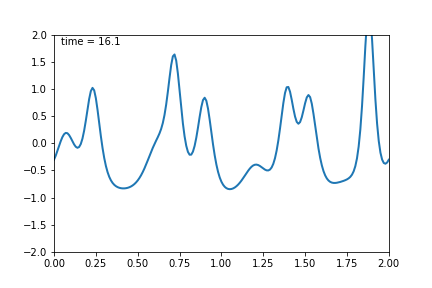

In [3]:
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'
from numba import jit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation

a=pd.read_csv("KZ_CD.dat",header=None)
data=a.values
xs=np.linspace(0,2,len(data[:,0]))
pstep=len(data[0,:])

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
# initialization function: plot the background of each frame
@jit
def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

# animation function.  This is called sequentially
@jit
def animate(i):
    line.set_data(xs, data[:,i])
    time_text.set_text('time = %.1f'%(0.05*i))
    return line, time_text

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=pstep+1, interval=50, blit=True)
plt.show()

In [ ]:
########## 2 revised Hopscotch diffirence format ##########

import numpy as np
import pandas as pd
from numba import jit
import matplotlib.pyplot as plt
import diff as df
%matplotlib inline
#np.seterr(all='ignore')

xini=0;xfin=2.0;xstep=200;
dx=(xfin-xini)/xstep;
xs=np.linspace(xini,xfin,xstep+1)

tini=0;tfin=20.0;tstep=100000000;
dt=(tfin-tini)/tstep;
ts=np.linspace(tini,tfin,tstep+1)

dp=0.05;
psmp = int(dp/dt);
pstep = int(tstep/psmp);

u=np.zeros((xstep+1,2))
data=np.zeros((xstep+1,pstep+1))

# for simple, we also here define
r=dt/dx
delta=0.022
coeffa=r/4
coeffb=0.5*r*(delta/dx)**2

### initialization
@jit(nopython=True)
def initial(u):
    for i in range(xstep+1):
        u[i,0]=np.cos(np.pi*(xini+i*dx))
    return u

### propagation
@jit(nopython=True)
def propagate(u,data,psmp,xstep,tstep):
    for i in range(0,tstep):#  n+1 time-points, with n time segments
        for j in range(i%2,xstep,2):
            u[j,1]=u[j,0] - coeffa*df.uux_2(u,j,0,xstep) - coeffb* df.uxxx_n2(u,j,0,xstep)
        for j in range((i+1)%2,xstep,2):
            u[j,1]=u[j,0] - coeffa*df.uux_2(u,j,0,xstep) - 0.25*coeffb* df.uxxx_n3(u,j,0,xstep)
        u[xstep,1]=u[0,1]
        u[:,0]=u[:,1]
        if((i+1)%psmp==0):
            #print("i do p\n", i//psmp,"!=",0,u[0,0],'!=','nan' )
            data[:,(i+1)//psmp]=u[:,0]
    return u,data
            
u=initial(u)
data[:,0]=u[:,0]
u,data=propagate(u,data,psmp,xstep,tstep)

a=pd.DataFrame(data)
a.to_csv("KZ_H.dat",header=None)

<IPython.core.display.Javascript object>


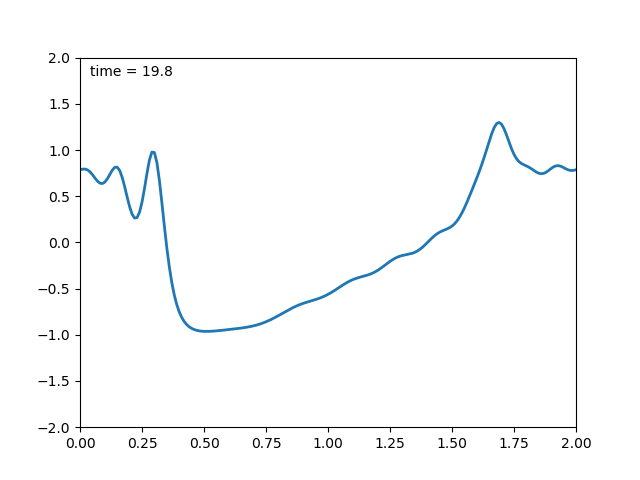

In [2]:
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'
from numba import jit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation

a=pd.read_csv("KZ_H.dat",header=None)
data=a.values
xs=np.linspace(0,2,len(data[:,0]))
pstep=len(data[0,:])

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
# initialization function: plot the background of each frame
@jit
def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

# animation function.  This is called sequentially
@jit
def animate(i):
    line.set_data(xs, data[:,i])
    time_text.set_text('time = %.1f'%(0.05*i))
    return line, time_text

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=pstep+1, interval=50, blit=True)
plt.show()

> 可见，Hopscotch格式在10秒有一次反转波形，而在20秒左右，又回到了初始的余弦波形状(虽然平滑性有所微微损失)。